# Parent Document Retrieval

Parent document retrieval (PDR) is a technique used in advanced RAG models to retrieve the full parent documents from which relevant child passages
(snippets) are derived. This retrieval process improves the context available to the RAG model, leading to more comprehensive and informative 
responses, especially for complex or nuanced queries.

Here are the core steps of parent document retrieval in RAG models:

  Data preprocessing: Split large documents into smaller chunks.

  Create embeddings: Convert each chunk into a numerical representation for efficient search.

  User query: The user submits a question.

  Chunk retrieval: Search for the most relevant chunks based on the query’s embedding.

  Identify parent documents: Find the original documents (or larger segments) for the shortlisted chunks.

  Retrieve parent documents: Get the full parent documents for better context.

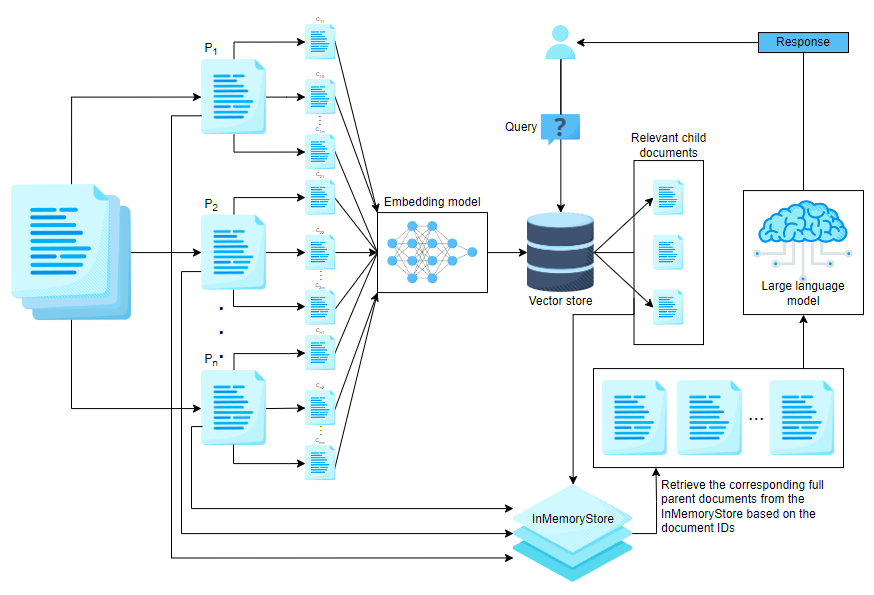




## Prepare the data

"""


Before importing the libraies below install them first


"""

### i) Import necessary modules

In [1]:
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.retrievers import ParentDocumentRetriever
from langchain.chains import RetrievalQA
from langchain_openai import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
import os

### ii) Set up the OpenAI API key

In [1]:
# OPENAI_API_KEY = os.environ["OPENAI_API_KEY"] = "XXXXXXXX"  # Add your OpenAI API key
# if OPENAI_API_KEY == "":
    # raise ValueError("Please set the OPENAI_API_KEY environment variable")

### iii) Define the text embedding function

"""
Creating an instance of OpenAIEmbeddings which converts document text into numerical representations suitable for retrieval.

"""

In [3]:
embeddings = OpenAIEmbeddings()

### iv) Load text data

initialize a list of TextLoader objects with paths to the text files ("/path/to/your/document1.txt" and "/path/to/your/document2.txt"). The TextLoader
class is used to load text documents from the specified paths.

iterate over each loader in the loaders list, loads the documents, and extends the docs list with the loaded documents.


In [4]:
loaders = [
    TextLoader('blog.langchain.dev_announcing-langsmith_.txt'),
    TextLoader('blog.langchain.dev_automating-web-research_.txt'),
]

docs = []
for l in loaders:
    docs.extend(l.load())

In [5]:
print(len(docs))
print(docs[0].page_content)

2
URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.

The blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’s still deceptively hard to take an application from prototype to production. The main issue that we see today is app

## 2. Retrieve full documents

### i) Full document splitting

 creates an instance of RecursiveCharacterTextSplitter with a specified chunk_size of 400 characters. We’ll use this splitter to divide the loaded 
documents into smaller text chunks (child documents) of the desired size, allowing for efficient searching of relevant passages.
                                                                        

In [6]:
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

### ii) Vector store and storage setup

use a Chroma vector store to store and search for the embeddings of the child documents.
                                             
use an InMemoryStore to keep track of the full parent documents associated with the child documents.


In [7]:
vectorstore = Chroma(
    collection_name="full_documents",
    embedding_function=OpenAIEmbeddings()
)

store = InMemoryStore()

### iii) Parent document retriever

Create an instance of the ParentDocumentRetriever class. This class handles the core logic of retrieving full parent documents based on child 
document similarity.


In [8]:
full_doc_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter
)

### iv) Adding documents

"""

Code Explanation : 

The add_documents method takes the list of documents (docs) loaded earlier and performs the following actions:

  Splitting documents: The child_splitter (defined earlier) splits each document into smaller text chunks (child documents).

  Embedding creation: The OpenAIEmbeddings function (defined earlier) creates vector representations (embeddings) for each child document.

  Indexing embeddings: The embeddings are stored in the Chroma vector store (defined earlier) with the collection name full_documents.

  Storing parent documents: The full original documents (not the child documents) are stored in the InMemoryStore (defined earlier). The store’s 
     document IDs will link the child document embeddings to their corresponding parent documents.

prints the document IDs stored in the in-memory store, providing a way to verify the successful storage of parent documents.

"""


In [9]:
full_doc_retriever.add_documents(docs)

print(list(store.yield_keys()))  # List document IDs in the store

['d0eb8407-9e3d-49f8-bd77-43e0834d993e', '8b2dacb3-dd0f-406c-af46-ac4c893bd03a']


### v) Similarity search and retrieval

"""

Code Explanation :

The similarity search in the Chroma vector store using the query "What is LangSmith?". The k=2 parameter retrieves the top 2 most similar child 
documents.

access the content of the retrieved child documents using the page_content attribute (assuming your documents have a page_content field). This helps 
to understand the context of the retrieved child documents.

The full_doc_retriever.invoke method is called with the same query, "What is LangSmith?" It uses the child document embeddings to retrieve the 
corresponding full parent documents from the InMemoryStore based on the document IDs

Finally,  access the full content of the retrieved parent documents using the page_content attribute again. Once retrieved, the full content 
of the parent documents is accessible, providing a comprehensive context for the query.


"""

In [10]:
sub_docs = vectorstore.similarity_search("What is LangSmith?", k=2)
print(len(sub_docs))

print(sub_docs[0].page_content)

retrieved_docs = full_doc_retriever.invoke("What is LangSmith?")

print(len(retrieved_docs[0].page_content))
print(retrieved_docs[0].page_content)

2
Today, we’re introducing LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.
11652
URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.


# 3. Retrieve larger chunks

In some cases, retrieving the entire parent document might not be ideal, especially if the documents are very large. Here’s how to retrieve larger 
chunks within the parent documents:

Text splitting for chunks and parents:

    Use two RecursiveCharacterTextSplitter instances:

    One is for creating parent documents (larger chunks) of a specific size.

    Another (with a smaller chunk size) is for creating child documents (text snippets) from the parent documents.

Vector store and storage setup (similar to full document retrieval):

     Create a Chroma vector store to index child document embeddings.

     Use an InMemoryStore to store the parent document chunks.


### i) Parent document retriever

"""
Code Explanation : 


we define two text splitters: one for larger chunks (parent_splitter) and another for smaller chunks (child_splitter). This differentiation ensures 
efficient handling of documents of varying sizes.

initialize a Chroma vector store named "split_parents" to store and search for embeddings of the split parent documents. It uses the OpenAIEmbeddings
function to create embeddings suitable for retrieval.

instantiate an in-memory store to maintain the parent documents associated with the split child documents. This enables seamless retrieval of full 
parent documents based on the child document embeddings.

The big_chunks_retriever instance of the ParentDocumentRetriever class is created, incorporating the vector store, document store, and splitters for 
child and parent documents.

The add_documents method of big_chunks_retriever adds the documents to the system, splitting them into smaller chunks for indexing and retrieval. The
subsequent print statement lists the document IDs stored in the in-memory store.

"""


In [11]:
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

vectorstore = Chroma(
    collection_name="split_parents",
    embedding_function=OpenAIEmbeddings()
)

store = InMemoryStore()

big_chunks_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

# Adding documents
big_chunks_retriever.add_documents(docs)
print(len(list(store.yield_keys())))  # List document IDs in the store

10


### ii) Similarity search and retrieval

"""

Code Explanation : 

perform a similarity search in the Chroma vector store (vectorstore) using the query "What is LangSmith?". The parameter k=2 specifies that we want to 
retrieve the top 2 most similar child documents.

Accessing the content of the first retrieved child document allows us to understand the context provided by this specific passage.

Using the invoke method of the big_chunks_retriever, we retrieve the relevant larger chunks of text based on the same query ("What is LangSmith?"). 
This method retrieves entire parent documents instead of just the child documents

print the length of the retrieved chunk to understand its size, which is larger than that of the child document.

Finally, we print the content of the retrieved chunk to access the larger context provided by the full parent document.

"""


In [12]:
sub_docs = vectorstore.similarity_search("What is LangSmith?", k=2)
print(len(sub_docs))

print(sub_docs[0].page_content)

retrieved_docs = big_chunks_retriever.invoke("What is LangSmith?")
print(len(retrieved_docs))

print(len(retrieved_docs[0].page_content))
print(retrieved_docs[0].page_content)

2
Today, we’re introducing LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.
3
1869
URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.

## 4. Integrate with `RetrievalQA`

"""

Code Explanation

initialize a RetrievalQA instance using the from_chain_type method, specifying the OpenAI language model (llm=OpenAI()), the type of retrieval chain 
(chain_type="stuff"), and the retriever (big_chunks_retriever) that retrieves relevant parent document chunks.

formulate a query, "What is LangSmith?" to retrieve relevant information.

The invoke method of the RetrievalQA object is called with the query. This triggers the RetrievalQA chain, where the big_chunks_retriever retrieves
relevant parent document chunks for the query.

Finally, the retrieved document chunks are passed to the specified language model (OpenAI in this case) to generate the answer, which is then printed 
as the response.

"""


In [13]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(),
                                chain_type="stuff",
                                retriever=big_chunks_retriever)

query = "What is LangSmith?"

response = qa.invoke(query)
print(response)

{'query': 'What is LangSmith?', 'result': ' LangSmith is a platform designed to help developers bridge the gap between prototype and production when developing LLM-powered applications. It provides tools for debugging, testing, evaluating, and monitoring LLM applications, and has been tested and used by companies like Snowflake and Boston Consulting Group for their own LLM-powered applications.'}
